In [3]:
%load_ext autoreload
%autoreload 2


## classic pydata stack
import os 
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier


%matplotlib inline 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)


import sys

import vanilla_NN as NN

sys.path.append('..')
from pipeline import *
from models import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
pipe = PairSingle_Pipeline(num_blocks=6)
dataset_fft = PolymerDataset(data_paths=["../data/AA66266AA.npy","../data/AA662266AA.npy"],pipeline=pipe)

Processing ../data/AA662266AA.npy: 100%|██████████| 19831/19831 [01:05<00:00, 304.12it/s]


In [5]:
train_data, test_data = train_test_split(dataset_fft)


In [6]:
model = PReLULSTM(input_dim=dataset_fft.num_features, output_dim=dataset_fft.num_classes, num_layers=1, hidden_dim=64)

In [7]:
model, test_metrics = train(train_data, model, batch_size=512, num_epochs=150, lr_rate=0.0005, test_dataset=test_data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lucastrg (use `wandb login --relogin` to force relogin)
2021-12-21 18:42:25.473000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 18:42:25.473030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=0/150, loss=0.569888, accuracy=81.4534
epoch=0/150, test_accuracy=86.4732
epoch=1/150, loss=0.283707, accuracy=87.5694
epoch=1/150, test_accuracy=89.2744
epoch=2/150, loss=0.233351, accuracy=89.8467
epoch=2/150, test_accuracy=90.4227
epoch=3/150, loss=0.208396, accuracy=91.1178
epoch=3/150, test_accuracy=91.5836
epoch=4/150, loss=0.188445, accuracy=92.2597
epoch=4/150, test_accuracy=92.2776
epoch=5/150, loss=0.173235, accuracy=92.8369
epoch=5/150, test_accuracy=92.7823
epoch=6/150, loss=0.163762, accuracy=93.3447
epoch=6/150, test_accuracy=93.0599
epoch=7/150, loss=0.156715, accuracy=93.6380
epoch=7/150, test_accuracy=93.1735
epoch=8/150, loss=0.151550, accuracy=93.9471
epoch=8/150, test_accuracy=93.5899
epoch=9/150, loss=0.147173, accuracy=94.1553
epoch=9/150, test_accuracy=93.8423
epoch=10/150, loss=0.144649, accuracy=94.2058
epoch=10/150, test_accuracy=93.9180
epoch=11/150, loss=0.141648, accuracy=94.3666
epoch=11/150, test_accuracy=93.9811
epoch=12/150, loss=0.139359, accurac

In [8]:
test(test_data,model=model)

{'accuracy': 0.9502839116719243,
 'f1_score': 0.9496678589678079,
 'precision': 0.957249549317538,
 'recall': 0.9422053231939164,
 'confusion_matrix': array([[0.958, 0.042],
        [0.058, 0.942]])}

In [9]:
np.save(arr=dataset_fft.labels.numpy(),file="backbone_bulky4_labels")

In [10]:
def kfold_cv_iter(y: np.ndarray, tx: np.ndarray, k: int = 5, seed: float = 1):
    """K-fold cross validation. Split data into k parts and iterate through the folds
    Args:
        y (np.ndarray): Label data
        tx (np.ndarray): Features data
        k (int, optional): Number of folds. Defaults to 5.
        seed (float, optional): Seed for randomization. Defaults to 1.
    Yields:
        Generator: (x_train, y_train, x_test, y_test)
    """
    num_row = y.shape[0]
    fold_size = int(num_row / k)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = list(set(range(num_row)) - set(test_indices))
        yield tx[train_indices], y[train_indices], tx[test_indices], y[test_indices]


In [11]:
def train_random_forest(x,y, k=5, n_estimators = 100):
    accuracies = []
    importances = []

    iter = kfold_cv_iter(y=y,tx=tx,k=k,seed=2)
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = n_estimators )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)
        importances.append(classifier.feature_importances_)

    accuracies = np.array(accuracies)
    importances = np.array(importances)
    
    return accuracies, importances, classifier

In [12]:
y = dataset_fft.labels.numpy()
tx = dataset_fft.data.numpy()
tx = tx.reshape((tx.shape[0],-1))
forest = train_random_forest(x=tx,y=y,k=5,n_estimators=100)

In [13]:
forest[0].mean()

0.948340694006309

In [14]:
def plot_feature_importances(feature_importances, names, num_blocks,title, savepath=None):

    df = pd.DataFrame()
    df['names'] = pd.Series(names*num_blocks)
    df['features'] = pd.Series(feature_importances)
    df['block_number'] = pd.Series([i  for i in range(1,num_blocks+1) for j in range(len(names))]) 

    f,a = plt.subplots(1,1,figsize=(30,15))
    g= sns.barplot(x='names', y='features', data=df, hue='block_number')
    g.set_title(title)
    g.set_xlabel("Feature names")
    g.set_ylabel("Feature importance")

    if savepath:
        plt.savefig(savepath, dpi=300)

In [15]:
features = forest[1].mean(axis=0)


In [16]:
forest[1].unique

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [ ]:
def a():
    return 3,4,5

In [ ]:
[1,2,*a(),6,7]

[1, 2, 3, 4, 5, 6, 7]

In [ ]:
dataset_fft.num_features

20

In [ ]:
names = ["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope","duration","max_amp","min_amp",
        "mean_amp",
        "std_amp",
        "dwell_time",
        "dwell_start",
        "dwell_end",
        "main_frequency",
        "secondary_frequency",
        "tertiary_frequency"]
len(names)

20

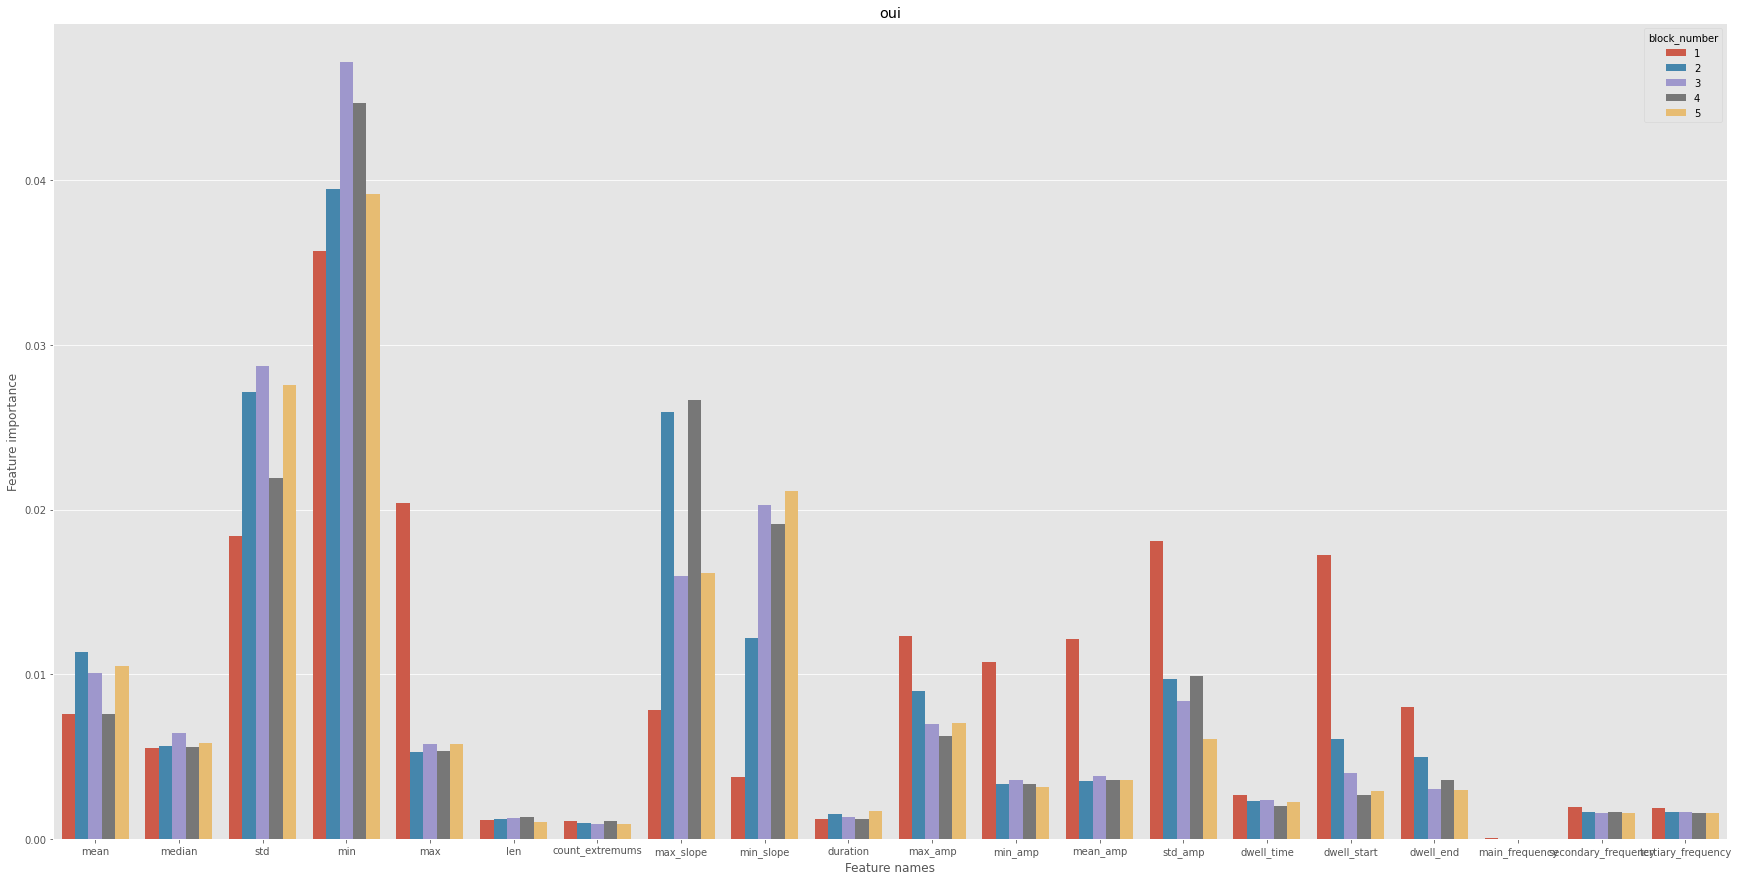

In [ ]:
plot_feature_importances(np.mean(forest[1], axis=0), names ,5, "oui") 

In [ ]:
print(dataset.full_dataset.numpy())

AttributeError: 

In [ ]:
for i in dataset.full_dataset
    print(i)

In [ ]:
mask = np.zeros((9), dtype=bool)

mask[0] = True

test = tx[:,np.logical_not(mask)]


In [ ]:
tx[0]

In [ ]:
y = np.load("backbone_bulky4_labels.npy",allow_pickle=True)

## Random forest with removing a feature

In [ ]:
names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

for i in range(9):
    tx = np.load("backbone_bulky4_data_1.npy",allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    mask = np.zeros((9), dtype=bool)
    mask[i] = True

    tx =tx[:,np.logical_not(mask)]


    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(names[i],": ",np.array(accuracies).mean())


## Random forest with different num_blocks

In [ ]:
for i in range(1,11):
    path = f"backbone_bulky4_data_{i}.npy"
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))

    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(f"num_blocks={i}",": ",np.array(accuracies).mean())

### Gradient boosting classifier with removing a feature

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

names=["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope"]
from sklearn.metrics import accuracy_score

for i in range(9):
    tx = np.load("backbone_bulky4_data_1.npy",allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))
    mask = np.zeros((9), dtype=bool)
    mask[i] = True

    tx =tx[:,np.logical_not(mask)]


    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier =GradientBoostingClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(names[i],": ",np.array(accuracies).mean())


 ## Gradient boosting classifier with different num_blocks

In [ ]:
for i in range(1,11):
    path = f"backbone_bulky4_data_{i}.npy"
    tx = np.load(path,allow_pickle=True)
    tx = tx.reshape((tx.shape[0],-1))

    iter = kfold_cv_iter(y=y,tx=tx,k=3,seed=2)
    accuracies = []
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = GradientBoostingClassifier(random_state=89,n_estimators = 100 )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)

    print(f"num_blocks={i}",": ",np.array(accuracies).mean())

In [ ]:
class PaddedDataset():

    def __init__(self, data_paths,seed=10):
        self.process(data_paths,seed)


    def process(self,data_paths,seed):

        raw_data = [np.load(data_path, allow_pickle=True) for data_path in data_paths]
        labels = [0,1]

    ## balance the dataset by removing signals that are too short or too long
    ## first we build the dataframe to know the lengths of the time series

        len_series = []

        for data in raw_data:
            lengths= []
            for row in data:
                ## length of time series
                lengths.append(row.shape[0])

            len_series.append(pd.Series(lengths))

        ## enforces that the first dataset is the smaller one in total size
        ## such that we can apply our balancing operations generally
        if len(len_series[0]) > len(len_series[1]):
            len_series.reverse()
            raw_data.reverse()
            labels.reverse()

        ## filter the dataset and remove signals that are:
        ## too short i.e. < len_series[0].quantile(0.1)
        ## too long i.e. > len_series[0].quantile(0.9)
        for i in range(2):
            mask = (len_series[i] > max(len_series[0].quantile(0.1),num_blocks)) & (len_series[i] < len_series[0].quantile(0.5))
            raw_data[i] = raw_data[i][mask]

        ## most likely, one dataset is still bigger than the other one
        ## therefore, we randomly sample data from the bigger dataset to create a new dataset of the same size as the small one 
        np.random.seed(seed=seed)

        # making sure the smallest dataset is the first one
        if len(raw_data[0]) > len(raw_data[1]):
            raw_data.reverse()
            labels.reverse()

        # randomly sampling and making a balanced dataset
        raw_data[1]  = np.random.permutation(raw_data[1])[:len(raw_data[0])]
        data=[]
        data_labels=[]
        
        max_length = max(len_series[0].max(), len_series[1].max())
        print("Max length",max_length)

        ## using our Input class to build the entire dataset and extracting features from each row
        for index, raw_data in enumerate(raw_data):
            for raw_series in raw_data:
                padded_series = self.pad(raw_series,max_length)
                data.append(padded_series)
                data_labels.append(labels[index])
        data = np.array(data)

        #normalizing features
        data = (data - data.mean(axis=0)) / data.std(axis=0)
        data_labels = np.array(data_labels)

        self.data = data
        self.labels = data_labels

        return self

    
    def pad(self,raw_series, max_length):

        l = max_length - raw_series.shape[0]
        x=raw_series[:,0]
        y= raw_series[:,1]

        if l > 0:
            res1 = np.concatenate((x, np.linspace(start= x[-1] + 0.01, stop= x[-1] + l*0.01 , num=l)),axis=None)
            res2 = np.concatenate((y, np.zeros(l)),axis=None)

        res = np.vstack((res1,res2)).T

        return res
        

In [ ]:
dataset = PaddedDataset(data_paths=["AA00400AA.npy","AA66466AA.npy"])

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = dataset.data, dataset.labels
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier = TimeSeriesForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
dataset.data[1]